# DL Lab 3.3 - Homework - Sentiment Classification with Transformers

Welcome to the DL Lab! Discussing sequence processing, you heard a lot about Recurrent Neural Networks (RNNs) and their different architectures. At last, one of the most breakthrough architectural mechanisms was discussed: the **self-attention** mechanism, which represents the key concept for the so called **Transformer** architecture.

In this homework, you will implement an **encoder** based on **multi-head attention** and use it for **sentiment classification on movie reviews**. Given the ability to pre-train Transformers on huge corpus of text, you will at last fine-tune a pre-trained BERT-like model for text classification.

***

**After completing this homework you will be able to**

- Use **subclassing** to efficiently create **custom layers** and **blocks**.
- Implement and use **scaled dot product attention** in **multiple attention heads**.
- **Fine-tune** and use **pre-trained Transformer models** for own tasks.

***

**Instructions**

- You'll be using Python 3 in the iPython based Google Colaboratory
- Lines encapsulated in "<font color='green'>`### START YOUR CODE HERE ###`</font>" and "<font color='green'>`### END YOUR CODE HERE ###`</font>" denote the code fragments to be completed by you.
- There's no need to write any other code.
- After writing your code, you can run the cell by either pressing `SHIFT`+`ENTER` or by clicking on the play symbol on the left side of the cell.
- We may specify "<font color='green'>`(≈ X LOC)`</font>" to tell you about how many lines of code you need to write. This is just a rough estimate, so don't feel bad if your code is longer or shorter.
- If you get stuck, check your Lecture and Lab notes and use the [discussion forum](https://moodle2.tu-ilmenau.de/mod/forum/view.php?id=102963) in Moodle.

Let's get started!



*Disclaimer*: This notebook is inspired from [Transformer model for language understanding](https://www.tensorflow.org/tutorials/text/transformer), [A Transformer Chatbot Tutorial with TensorFlow 2.0](https://blog.tensorflow.org/2019/05/transformer-chatbot-tutorial-with-tensorflow-2.html), and 
[Hugging Face: State-of-the-Art NLP in ten lines of TF 2.0](https://blog.tensorflow.org/2019/11/hugging-face-state-of-art-natural.html).

# 0 - Test for GPU
Execute the code below for printing the TF version and testing for GPU availability.

In [1]:
#@title Print TF version and GPU stats
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import sys
print('TensorFlow version:', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name), '', sep='\n')
!nvidia-smi

TensorFlow version: 2.4.0
Found GPU at: /device:GPU:0

Thu Jan 21 23:11:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    33W /  70W |    227MiB / 15079MiB |      7%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                 

# 1 - Movie Review Dataset

You will train a sentiment analysis model for classifying movie reviews as either "positive" or "negative", depending on the text of the review. As dataset, you will be using the [IMDB Large Movie Review Dataset](https://ai.stanford.edu/%7Eamaas/data/sentiment/) consisting of 50k annotated movie reviews.

## 1.1 - Download and Prepare Data

Keras comes with a [convenient loader for the IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb). The reviews are already preprocessed, i.e., each review is encoded as list of word indices.


In [2]:
VOCABULARY_SIZE = 20000  # Only consider the top 20k words
MAX_LENGTH = 200  # Only consider the first 200 words of each movie review

# Load dataset
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.imdb.load_data(num_words=VOCABULARY_SIZE)

print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


25000 Training sequences
25000 Validation sequences


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


Next, you pad each review to the maximum length. Instead of the end of the sequence, the start of each sequence is marked with a specific word index, i.e., `1`. Hence, we pad at the start of each sequence using `padding='pre'`.

In [3]:
# Truncate and pad to `MAX_LENGTH`
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, 
                                                        maxlen=MAX_LENGTH, 
                                                        padding='pre')
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val, 
                                                      maxlen=MAX_LENGTH, 
                                                      padding='pre')

At last, we convert the data to a TF dataset:

In [4]:
BATCHSIZE = 32

ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds_val = tf.data.Dataset.from_tensor_slices((x_val, y_val))

ds_train = ds_train.shuffle(10000).batch(BATCHSIZE, drop_remainder=True)
ds_val = ds_val.batch(BATCHSIZE, drop_remainder=True)

## 1.2 - Text <-> Sequence Conversion

Let's create some utility functions for converting a sequence into text and vice versa. Ultimately, we want to have a look on few examples as well as convert novel texts for model testing.

In [5]:
word_idx = tf.keras.datasets.imdb.get_word_index()
word_idx = {k:(v+3) for k,v in word_idx.items()}
word_idx["<PAD>"] = 0
word_idx["<START>"] = 1
word_idx["<UNK>"] = 2
word_idx["<UNUSED>"] = 3
idx_word = dict(map(reversed, word_idx.items()))

def sequence_to_text(sequence):
  text = [idx_word.get(idx) for idx in np.array(sequence) if idx]
  return ' '.join(text)

def text_to_sequence(text):
  sequence = tf.keras.preprocessing.sequence.pad_sequences(
      [[1]+[word_idx.get(word) if word in word_idx.keys() else 2 for word in text.lower().split(' ')]],
      maxlen=MAX_LENGTH,
      padding='pre')[0]
  sequence[sequence>VOCABULARY_SIZE] = 2
  return sequence

sequence_to_text(text_to_sequence('this is a test'))

'<START> this is a test'

In [6]:
for text, label in zip(x_train[:5], y_train[:5]):
  print(label, sequence_to_text(text))

1 and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was someone's life af

# 2 - GRU Baseline Model

In order to compare the results of the Transformer models, you will build a RNN model as baseline.

**Task**: Complete the function `build_model_gru` creating following model for sequence classification:
- Embedding layer for encoding each word into vector of size `embedding_dim`.
- Gated recurrent unit with 128 units
- 10% Dropout on GRU's output
- Dense layer with 128 units, ReLU activation, and `.1` dropout rate
- Dense layer for binary classification.

Compile the model using `accuracy` as metric and Adam optimizer with learning rate `1e-4`.

In [7]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

def build_model_gru(vocabulary_size, embedding_dim, batch_size, sequence_length, summary=True):

  ### START YOUR CODE HERE ###  (≈8 LOC)
  inputs = layers.Input(batch_input_shape=(batch_size, sequence_length))
  x = layers.Embedding(vocabulary_size, embedding_dim)(inputs)
  x = layers.GRU(128,
                 stateful=True,
                 )(x)
  x = layers.Dropout(.1)(x)
  x = layers.Dense(128, activation = 'relu')(x)
  x = layers.Dropout(.1)(x)
  out = layers.Dense(1, 
                     activation='sigmoid'
                     )(x)
  model = Model(inputs, out)
  model.compile(loss='binary_crossentropy',
                optimizer=Adam(lr=1e-4),
                metrics='accuracy')





  ### END YOUR CODE HERE ###

  if summary:
    print(model.summary())
  
  return model

EarlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=3, 
                                                         restore_best_weights=True)

Now train the model. It should converge to $\approx 87\%$ validation accuracy in less than 10 epochs.

In [8]:
#@title `plot_history()` definition
from matplotlib import pyplot as plt

def plot_history(history, ylim=None):
  fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, dpi=150)
  epochs = np.array(history.epoch)+1
  ax1.plot(epochs, history.history['loss'], 
           label='training')
  if history.history.__contains__('val_loss'):
    ax1.plot(epochs, history.history['val_loss'], 
             label='validation')
  if history.history.__contains__('lr'):
    ax1b = ax1.twinx()
    ax1b.plot(epochs, history.history['lr'], 
              'g-', linewidth=1)
    ax1b.set_yscale('log')
    ax1b.set_ylabel('Learning Rate', color='g')

  ax1.set_ylabel('Cross-Entropy Loss')
  ax1.set_yscale('log')
  ax1.grid(alpha=.5)

  ax2.plot(epochs, history.history['accuracy'], 
           label='training')
  if history.history.__contains__('val_accuracy'):
    ax2.plot(epochs, history.history['val_accuracy'], 
             label='validation')
    ax2.legend()
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.grid(alpha=.5)
  if ylim:
    ax2.set_ylim(ylim)
  
  plt.show() 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 200)]               0         
_________________________________________________________________
embedding (Embedding)        (32, 200, 32)             640000    
_________________________________________________________________
gru (GRU)                    (32, 128)                 62208     
_________________________________________________________________
dropout (Dropout)            (32, 128)                 0         
_________________________________________________________________
dense (Dense)                (32, 128)                 16512     
_________________________________________________________________
dropout_1 (Dropout)          (32, 128)                 0         
_________________________________________________________________
dense_1 (Dense)              (32, 1)                   129   

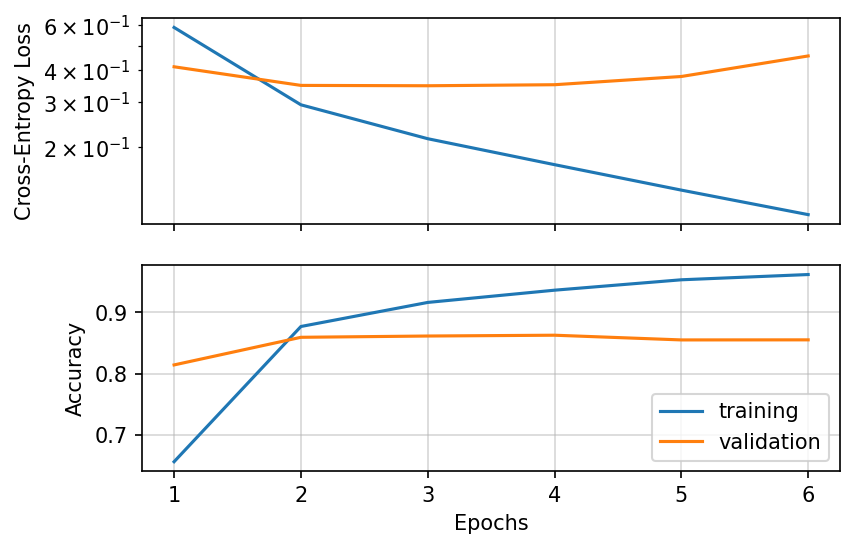

In [9]:
EMBEDDING_DIM = 32 # Embedding size for each word

gru_model = build_model_gru(VOCABULARY_SIZE, EMBEDDING_DIM, BATCHSIZE, MAX_LENGTH)
gru_history = gru_model.fit(ds_train,
                            batch_size=BATCHSIZE,
                            epochs=10,
                            validation_data=ds_val,
                            callbacks=[EarlyStoppingCallback]
                            )
plot_history(gru_history)

In [10]:
weights_file = '/tmp/gru_model_weights'

# 1) Save weights of `gru_model`
gru_model.save_weights(weights_file)

# 2) Build `tweety` model
gru_inference = build_model_gru(VOCABULARY_SIZE, EMBEDDING_DIM, 1, MAX_LENGTH)

# 3) Load the saved weights into `gru_inference` model
gru_inference.load_weights(weights_file)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(1, 200)]                0         
_________________________________________________________________
embedding_1 (Embedding)      (1, 200, 32)              640000    
_________________________________________________________________
gru_1 (GRU)                  (1, 128)                  62208     
_________________________________________________________________
dropout_2 (Dropout)          (1, 128)                  0         
_________________________________________________________________
dense_2 (Dense)              (1, 128)                  16512     
_________________________________________________________________
dropout_3 (Dropout)          (1, 128)                  0         
_________________________________________________________________
dense_3 (Dense)              (1, 1)                    129 

Some tests:

In [11]:
def predict_review(text, model):
  sample = tf.expand_dims(text_to_sequence(text), 0)
  score = model.predict(sample)[0,0]
  return score

In [12]:
for text in ['Best movie of all time.',
             "I've had mosquito bites that were more passionate than this undead unrequited and altogether unfun pseudoromantic riff on romeo and juliet",
             "It is a triumph of the film, and proof of its solid value and of the sense of its director and all concerned, that a human touch is not lost.",
             "This movie is like if aliens studied humanity and tried to make their own movie in an attempt to communicate with us. This simulacrum contains all the requisite pieces of a movie, but humanity got lost in translation.",
             "The people who made this movie — which, as always, is set up for a sequel — will be laughing all the way to the bank. But isn't there someone in that bank who can lock them all inside a safety-deposit vault and throw away the key?",
             ]:
  print(predict_review(text, gru_inference), ':', text)

0.8500302 : Best movie of all time.
0.7140569 : I've had mosquito bites that were more passionate than this undead unrequited and altogether unfun pseudoromantic riff on romeo and juliet
0.79452187 : It is a triumph of the film, and proof of its solid value and of the sense of its director and all concerned, that a human touch is not lost.
0.7047153 : This movie is like if aliens studied humanity and tried to make their own movie in an attempt to communicate with us. This simulacrum contains all the requisite pieces of a movie, but humanity got lost in translation.
0.4096615 : The people who made this movie — which, as always, is set up for a sequel — will be laughing all the way to the bank. But isn't there someone in that bank who can lock them all inside a safety-deposit vault and throw away the key?


# 3 - Transformers

Before the rise of Transformer models, the state of the art in any sequence related tasks (translation, image captioning, ...) was basically a RNN with added attention mechanism (compare with Lecture 3.2 - Attention).

Transformer architectures also rely on attention mechanisms, but without any recurrent processing. The impactful [*Attention is all you need*](https://arxiv.org/abs/1706.03762) paper highlights that the attention mechanism alone is as powerful as RNNs with added attention. However, recurrent processing requires that sequences are processed strictly in order both during forward and backward propagation. In Transformers, a sequence can be processed *at once*, which significantly reduces training times and allows for much larger datasets to be efficiently processed.

## 3.1 - Define Multi-head Attention Encoder

The heart of each transformer is an encoder-decoder structure. The encoder processes the input sequence to generate encodings of each token in such way that they contain contextual information, i.e., the encoder encodes which tokens of the input sequence are relevant to each other. The decoder part then transforms these token encodings to generate an output sequence. 

### Scaled Dot-Product Attention

In order to compute this contextual token relevancy, both the encoder and the decoder are using a specific type of attention: the **scaled dot-product attention**, which allows for dynamic computation of the weighted average of the features of the input tokens. "Dynamic" means that the weights are not pre-defined but depend on the actual values of the tokens.

Therefore, for each token embedding $x_i \in X$ of the input sequence, a set of vectors is computed: a **query** vector $q_i$, a **key** vector $k_i$, and a **value** vector $v_i$. These vectors are computed by linear projection using trainable weight matrices:
$$
q_i = x_i W_q\\
k_i = x_i W_k\\
v_i = x_i W_v.
$$

As you can see, computing these vectors is exactly the same as computing the output of a fully connected layer. You will also implement it as such. ;-)

The attention weight 

$$a_{ij} = q_i \cdot k_j$$

from token $i$ to token $j$ is based on the similarity between the query vector $q_i$ of token $i$ and the key vector $k_j$ of token $j$, and the dot product is used as similarity metric. Hence, the attention weights for all tokens can be computed by matrix-matrix multiplication $Q K^T$, where Q (K) contains the query (key) vectors for all input tokens of the sequence. In addition, we normalize the attention weights so that they are between $0$ and $1$ and sum up to $1$. As the average value of the dot product increases with increasing embedding dimension $d_k$, we also divide by $\sqrt{d_k}$ to mitigate the amount by which the increase in dimension increases the dot product.

Ultimately, the hidden representations of the tokens with attention is computed by multiplying the scaled attention weights with the value vectors $V$:

$$H(Q, K, V) = \text{softmax}\left( \frac{QK^T}{\sqrt{d_k}}\right)V$$.

<img src='https://3.bp.blogspot.com/-mnlTQLXKuiU/XfgOSZ2eBsI/AAAAAAAAB0w/6jjXEtzO6_M1IlPkNVzR_wcmP62u0jI0ACLcBGAsYHQ/s1600/attention.png' width="760">

### Multi-head Attention

Having multiple attention heads, each computing the scaled dot-product attention as described above, the model can learn different relevance relations between the input tokens. The output of all heads is concatenated and propagated through a linear layer reducing the dimension to the hidden size of the model. Each head will process a different chunk of the token embedding. To speed up computation, we first compute the $Q, K, V$ matrices and then split and distribute them across the different heads. You can think of it as stacking all the $W_q^{(h)}, W_k^{(h)}, W_v^{(h)}$ weight matrices of the $h$ different heads into combined weight matrices $W_q, W_k, W_v$.


**Task**: Complete the `MultiHeadSelfAttention` class defined below.
- Initialize the [dense layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) `query_linear`, `key_linear`, `value_linear` for computing the linear transformations of the inputs. Each layer shall have `hidden_size` neurons, use linear activation and no bias.
- Compute the dot product attention in the `attention` method using [`tf.matmul()`](https://www.tensorflow.org/api_docs/python/tf/linalg/matmul). 

In [13]:
class MultiHeadSelfAttention(layers.Layer):
  ''' Multi-head self attention layer consisting of four parts:
    - linear layers and separation into multiple heads
    - scaled dot product attention
    - concatenation of multiple heads
    - final linear layer
  '''

  def __init__(self, hidden_size, num_heads=4):
    assert hidden_size % num_heads == 0, \
      'The hidden size (={}) has to be divisble by number of heads (={})'.format(
          hidden_size, num_heads)
    super(MultiHeadSelfAttention, self).__init__()
    self.hidden_size = hidden_size
    self.num_heads = num_heads
    self.projection_dim = hidden_size // num_heads

    # Layers for linearly projecting to queries, keys and values
    ### START YOUR CODE HERE ###  (3 LOC)
    self.query_linear = layers.Dense(units = hidden_size, activation = 'linear', use_bias=False)
    self.key_linear =  layers.Dense(units = hidden_size, activation = 'linear', use_bias=False)
    self.value_linear =  layers.Dense(units = hidden_size, activation = 'linear', use_bias=False)
    ### END YOUR CODE HERE ###
    self.output_linear = layers.Dense(hidden_size, name='transform_output')


  def attention(self, query, key, value):
    ''' Apply scaled dot product attention
    
    Args:
      query : Tensor with shape (batch_size, num_heads, sequence_length, hidden_size/num_heads)
      key : Tensor with shape (batch_size, num_heads, sequence_length, hidden_size/num_heads)
      value : Tensor with shape (batch_size, num_heads, sequence_length, hidden_size/num_heads)

    Returns:
      Tensor with shape (batch_size, num_heads, sequence_length, hidden_size/num_heads)
    '''

    # compute dot product attention
    ### START YOUR CODE HERE ###  (1 LOC)
    logits = tf.matmul(query, key, transpose_b=True)
    ### END YOUR CODE HERE ###

    # scale logits
    dim_key = tf.cast( tf.shape(key)[-1], tf.float32 )
    logits = logits / tf.math.sqrt(dim_key)

    # apply softmax
    attention_weights = tf.nn.softmax(logits, axis=-1, name='attention_weights')

    # multiply attention weights with value
    output = tf.matmul(attention_weights, value)

    return output


  def separate_heads(self, x, batch_size):
    ''' Separate x into different heads and transpose resulting value. 
    
    Args:
      x : Tensor with shape (batch_size, sequence_length, hidden_size)
    
    Returns:
      Tensor with shape (batch_size, num_heads, sequence_length, hidden_size/num_heads)
    '''
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
    return tf.transpose(x, perm=[0,2,1,3])


  def combine_heads(self, x, batch_size):
    ''' Combine splitted tensor.

    Args:
      x : Tensor with shape (batch_size, num_heads, sequence_length, hidden_size/num_heads)

    Returns:
      Tensor with shape (batch_size, sequence_length, hidden_size)
    '''
    x = tf.transpose(x, perm=[0,2,1,3])
    return tf.reshape(x, (batch_size, -1, self.hidden_size))


  def call(self, inputs):
    ''' Apply self-attention mechanism to inputs.

    Args:
      inputs : Tensor with shape (batch_size, sequence_length, hidden_size)

    Returns:
      Tensor with shape (batch_size, sequence_length, hidden_size)
    '''
    # store batch_size
    batch_size = tf.shape(inputs)[0]
    
    # transform q, k, v by linear projection
    query = self.query_linear(inputs)
    key = self.key_linear(inputs)
    value = self.value_linear(inputs)
    
    # separate q, k, v into heads
    query = self.separate_heads(query, batch_size)
    key = self.separate_heads(key, batch_size)
    value = self.separate_heads(value, batch_size)

    # apply self-attention
    attention = self.attention(query, key, value)
    
    # combine heads
    attention = self.combine_heads(attention, batch_size)

    # (batch_size, sequence_length, hidden_size)
    attention_output = self.output_linear(attention)

    return attention_output

Each encoder layer of the transformer consists of the multi-head attention layer, and two dense layers with dropout.

In [14]:
class EncoderLayer(layers.Layer):
  def __init__(self, embedding_dim, ff_dim, num_heads=4, rate=.1):
    super(EncoderLayer, self).__init__()
    self.attention = MultiHeadSelfAttention(embedding_dim, num_heads)
    self.ffn = tf.keras.Sequential( [layers.Dense(ff_dim, activation='relu'), 
                                     layers.Dense(embedding_dim)] )
    self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)

  def call(self, inputs, training):
    attn_output = self.attention(inputs)
    attn_output = self.dropout1(attn_output, training=training)
    out = self.layernorm1(inputs + attn_output)
    ffn_output = self.ffn(out)
    ffn_output = self.dropout2(ffn_output, training=training)
    return self.layernorm2(out + ffn_output)

Unlike RNNs, the transformer model has no meaning of sequences of operations for a set of inputs. Hence it is important to keep track of the order of inputs. You can either train an *positional embedding* using the `EmbeddingWithPositionalEmbedding` layer below (the model then learns to encode positions), or use the *positional encoding* layer `EmbeddingWithPositionalEncoding`. Both should perform equally well.

In [15]:
class EmbeddingWithPositionalEmbedding(layers.Layer):
  def __init__(self, max_length, vocabulary_size, embedding_dim):
    super(EmbeddingWithPositionalEmbedding, self).__init__()
    self.token_emb = layers.Embedding(vocabulary_size, embedding_dim)
    self.position_emb = layers.Embedding(max_length, embedding_dim)

  def call(self, x):
    max_length = tf.shape(x)[-1]
    positions = tf.range(start=0, limit=max_length, delta=1)
    positions = self.position_emb(positions)
    x = self.token_emb(x)
    return x + positions

In [16]:
class EmbeddingWithPositionalEncoding(layers.Layer):
  def __init__(self, max_length, vocabulary_size, embedding_dim):
    super(EmbeddingWithPositionalEncoding, self).__init__()
    self.embedding_dim = embedding_dim
    self.vocabulary_size = vocabulary_size
    self.token_emb = layers.Embedding(vocabulary_size, embedding_dim)
    self.pos_encoding = self.positional_encoding(vocabulary_size)

  def _get_angles(self, position, i):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(self.embedding_dim, tf.float32))
    return position * angles

  def positional_encoding(self, position):
    angle_rads = self._get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(self.embedding_dim, dtype=tf.float32)[tf.newaxis, :]
        )
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, x):
    x = self.token_emb(x)
    positions = self.pos_encoding[:, :tf.shape(x)[1], :]
    return x + positions

## 3.2 - Create Model

Now you can use the custom layers to build your own transformer encoder:

In [17]:
def build_transformer_encoder(embedding_dim, num_heads, ff_dim, max_length, vocabulary_size, learning_rate=1e-3, summary=True):
  
  input_ = layers.Input( shape=(max_length,) )
  
  # choose one
  #embedding_layer = EmbeddingWithPositionalEmbedding(max_length, vocabulary_size, embedding_dim)
  embedding_layer = EmbeddingWithPositionalEncoding(max_length, vocabulary_size, embedding_dim)
  x = embedding_layer(input_)

  transformer_block = EncoderLayer(embedding_dim, ff_dim, num_heads)
  x = transformer_block(x)
  x = layers.GlobalAveragePooling1D()(x)
  x = layers.Dropout(.1)(x)
  x = layers.Dense(x.shape[1], activation='relu')(x)
  x = layers.Dropout(.1)(x)
  output_ = layers.Dense(1, activation='sigmoid')(x)

  model = Model(input_, output_)

  model.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=learning_rate,
                               beta_2=0.98,
                               epsilon=1e-9),
                metrics='accuracy')

  if summary:
    print(model.summary())

  return model

Training transformers is typically done using learning rate warm-up. Instead of making large updates from the very beginning, we start to learn slowly by gradually increasing the learning rate from 0 to a certain value. After this warm-up, the learning rate decays again.

The [*Attention is all you need* paper](https://arxiv.org/abs/1706.03762) provides following formula, which we implement as custom learning rate scheduler:

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$.

In [18]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  
  def __init__(self, d_model, warmup_steps=200):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Check the scheduled learning rate:

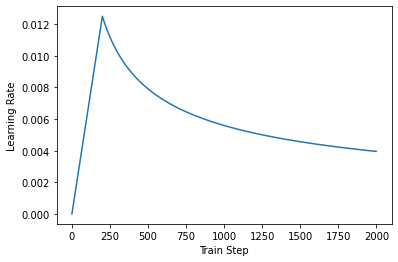

In [19]:
from matplotlib import pyplot as plt

EMBEDDING_DIM = 32

LearningRateSchedule = CustomSchedule(EMBEDDING_DIM)

plt.plot(LearningRateSchedule(tf.range(2000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

## 3.3 - Train and Evaluate Model

Finally, you can train your transformer! If everything works well, the model should immediately converge and start overfitting after only few epochs.

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_with_positional_en (None, 200, 32)           640000    
_________________________________________________________________
encoder_layer (EncoderLayer) (None, 200, 32)           5328      
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0   

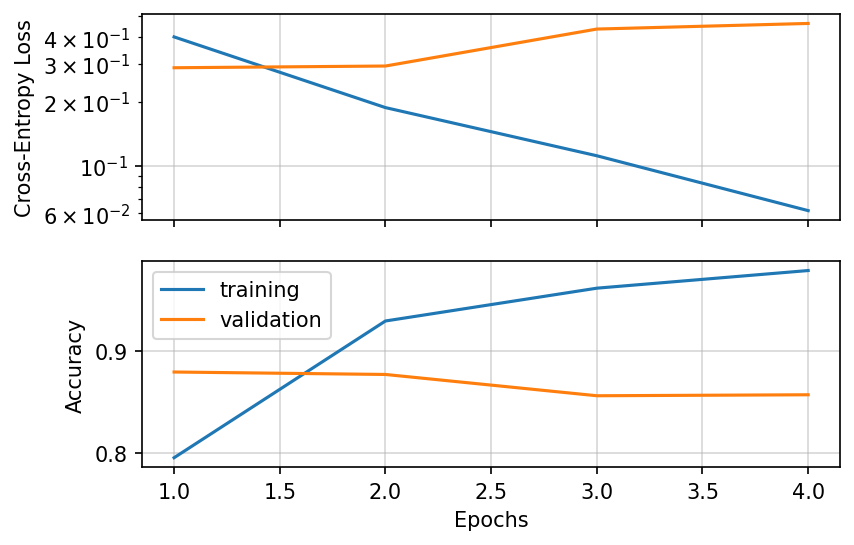

In [20]:
num_heads = 4 # Number of attention heads
ff_dim = 16 # Hidden layer size in feed forward network inside transformer

BATCHSIZE = 32

LearningRateSchedule = CustomSchedule(EMBEDDING_DIM)

EarlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=3, 
                                                         restore_best_weights=True)

my_transformer = build_transformer_encoder(EMBEDDING_DIM, num_heads, ff_dim, 
                                           MAX_LENGTH,
                                           VOCABULARY_SIZE,
                                           learning_rate=LearningRateSchedule
                                           )

history = my_transformer.fit(ds_train,
                             batch_size=BATCHSIZE,
                             epochs=10,
                             validation_data=ds_val,
                             callbacks=[EarlyStoppingCallback]
                             )
plot_history(history)

In [21]:
for text in ['Best movie of all time.',
             "I've had mosquito bites that were more passionate than this undead unrequited and altogether unfun pseudoromantic riff on romeo and juliet",
             "It is a triumph of the film, and proof of its solid value and of the sense of its director and all concerned, that a human touch is not lost.",
             "This movie is like if aliens studied humanity and tried to make their own movie in an attempt to communicate with us. This simulacrum contains all the requisite pieces of a movie, but humanity got lost in translation.",
             "The people who made this movie — which, as always, is set up for a sequel — will be laughing all the way to the bank. But isn't there someone in that bank who can lock them all inside a safety-deposit vault and throw away the key?",
             ]:
  print(predict_review(text, my_transformer), ':', text)

0.64694035 : Best movie of all time.
0.6239316 : I've had mosquito bites that were more passionate than this undead unrequited and altogether unfun pseudoromantic riff on romeo and juliet
0.61214906 : It is a triumph of the film, and proof of its solid value and of the sense of its director and all concerned, that a human touch is not lost.
0.18688433 : This movie is like if aliens studied humanity and tried to make their own movie in an attempt to communicate with us. This simulacrum contains all the requisite pieces of a movie, but humanity got lost in translation.
0.25567454 : The people who made this movie — which, as always, is set up for a sequel — will be laughing all the way to the bank. But isn't there someone in that bank who can lock them all inside a safety-deposit vault and throw away the key?


# 4 - Pre-Trained Transformers: DistilBERT

Achieving state of the art performance across 11 different NLP tasks BERT represents a major breakthrough in NLP research. Unfortunately, the model is very large and memory consuming. [DistilBERT](https://huggingface.co/transformers/model_doc/distilbert.html) is a "distilled" version of BERT, i.e., it is significantly smaller and faster but retains most of BERT's accuracy.

We will use a neat library for using the pre-trained transformers: [Hugging Face](https://blog.tensorflow.org/2019/11/hugging-face-state-of-art-natural.html). Originally developed for PyTorch, it also supports TensorFlow since 2019. If you want to find out how to use that library for different tasks and on your own data, check out their [documentation](https://huggingface.co/transformers/custom_datasets.html) and [examples](https://huggingface.co/transformers/examples.html).

In [22]:
!pip install transformers==4.1.1 # Install HuggingFace library

## Input Tokenization

The models come with their own tokenizers. Hence, we need to convert the already tokenized IMDB sequences back to natural language. Eventually, we can feed the texts into the [BERT tokenizer](https://huggingface.co/transformers/model_doc/distilbert.html#distilberttokenizer):

In [23]:
from transformers import DistilBertTokenizerFast

DB_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased',
                                                       max_length=200,
                                                       do_lower_case=True,
                                                       add_special_tokens=True,
                                                       )

In [24]:
def sequence_to_text(sequence):
  text = [idx_word.get(idx) for idx in np.array(sequence) if idx > 1]
  return ' '.join(text)

VOCABULARY_SIZE = 20000  # Only consider the top 20k words
MAX_LENGTH = 200  # Only consider the first 200 words of each movie review

# Load dataset
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.imdb.load_data(num_words=VOCABULARY_SIZE)

# Conversion: tokenized sequence -> text -> DistilBERT tokenized sequence
x_val = DB_tokenizer([sequence_to_text(x) for x in x_val],
                     max_length=200,
                     truncation=True,
                     padding=True)
x_train = DB_tokenizer([sequence_to_text(x) for x in x_train],
                       max_length=200,
                       truncation=True,
                       padding=True)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [25]:
BATCHSIZE = 16

DB_ds_train = tf.data.Dataset.from_tensor_slices((dict(x_train), y_train))
DB_ds_val = tf.data.Dataset.from_tensor_slices((dict(x_val), y_val))

DB_ds_train = DB_ds_train.shuffle(100).batch(BATCHSIZE, drop_remainder=True)
DB_ds_val = DB_ds_val.batch(BATCHSIZE, drop_remainder=True)

## Fine-tuning Pre-Trained Classification Transformer Model

The HuggingFace library already provides pre-trained models with heads suitable for different tasks, e.g., [sequence classification](https://huggingface.co/transformers/model_doc/distilbert.html#tfdistilbertforsequenceclassification). We can use such model and fine-tune the weights of the pre-trained model. Note that you have to specify the number of labels `num_labels` to be classified. We have a binary classification task, hence we define `num_labels=2`:

In [26]:
from transformers import TFDistilBertForSequenceClassification

def build_model_distilbert():

  DBert = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',
                                                                num_labels=2)  
  DBert.classifier.activation = tf.keras.activations.softmax
  
  DBert.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(lr=3e-5,
                               epsilon=1e-8,
                               clipnorm=1.0),
                metrics='accuracy')
  
  return DBert

Also, note line 7 in the last cell: 

`DBert.classifier.activation = tf.keras.activations.softmax`.

The classification heads of the pre-trained model architectures return logits, i.e., unnormalized classification scores. To deal with such, you may either specify the loss to be computed from logits: 

`loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)`

during model compilation or change the activation function of the classification layer as shown above.

In [27]:
DB_model = build_model_distilbert()

bert_history = DB_model.fit(DB_ds_train,
                            epochs=2, 
                            validation_data=DB_ds_val,
                            )

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_27', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f4b601bdd90> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f4b601bdd90> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


1562/1562 [==============================] - ETA: 0s - loss: 0.3574 - accuracy: 0.8406

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


1562/1562 [==============================] - 796s 490ms/step - loss: 0.3574 - accuracy: 0.8407 - val_loss: 0.2524 - val_accuracy: 0.8964
Epoch 2/2
1562/1562 [==============================] - 763s 489ms/step - loss: 0.1809 - accuracy: 0.9328 - val_loss: 0.2805 - val_accuracy: 0.8945


In [28]:
def predict_review(text, model):
  sample = DB_tokenizer.encode(text,
                     max_length=200,
                     truncation=True,
                     padding=True,
                     return_tensors='tf')
  score = model.predict(sample)[0][0,1]
  return score

for text in ['Best movie of all time.',
             "I've had mosquito bites that were more passionate than this undead unrequited and altogether unfun pseudoromantic riff on romeo and juliet",
             "It is a triumph of the film, and proof of its solid value and of the sense of its director and all concerned, that a human touch is not lost.",
             "This movie is like if aliens studied humanity and tried to make their own movie in an attempt to communicate with us. This simulacrum contains all the requisite pieces of a movie, but humanity got lost in translation.",
             "The people who made this movie — which, as always, is set up for a sequel — will be laughing all the way to the bank. But isn't there someone in that bank who can lock them all inside a safety-deposit vault and throw away the key?",
             ]:
  print(predict_review(text, DB_model), ':', text)

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


0.9877521 : Best movie of all time.


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


0.0173394 : I've had mosquito bites that were more passionate than this undead unrequited and altogether unfun pseudoromantic riff on romeo and juliet
0.9973821 : It is a triumph of the film, and proof of its solid value and of the sense of its director and all concerned, that a human touch is not lost.
0.031046843 : This movie is like if aliens studied humanity and tried to make their own movie in an attempt to communicate with us. This simulacrum contains all the requisite pieces of a movie, but humanity got lost in translation.
0.15876125 : The people who made this movie — which, as always, is set up for a sequel — will be laughing all the way to the bank. But isn't there someone in that bank who can lock them all inside a safety-deposit vault and throw away the key?


***

# Congratulations!

You may now submit your notebook to moodle:
- Save the notebook (`CTRL`+ `s` or '*File*' -> '*Save*')
- Click on '*File*' -> '*Download .ipynb*' for downloading the notebook as IPython Notebook file.
- Upload the downloaded IPython Notebook file to **Moodle**.